<a href="https://colab.research.google.com/github/skotipalli/mai-agents/blob/main/Agentic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern AI Enterprise Agentic RAG System

## 1. Understanding the Architecture


```
┌─────────────────────────────────────────────────────────────────┐
│                    USER QUERY (HR Request)                       │
│         "Can I take a 3-month sabbatical?" / "Promote X?"      │
└────────────────────────┬────────────────────────────────────────┘
                         │
                    ┌────▼─────┐
                    │ ROUTER    │  (Decides which agents to invoke)
                    └────┬─────┘
                         │
        ┌────────────────┼────────────────┬──────────────────┐
        │                │                │                  │
   ┌────▼────┐    ┌──────▼──────┐   ┌─────▼──────┐    ┌─────▼─────┐
   │POLICY   │    │ ELIGIBILITY │   │ COMPLIANCE │    │  ADVISOR  │
   │AGENT    │    │ AGENT       │   │ AGENT      │    │  AGENT    │
   └────┬────┘    └──────┬──────┘   └─────┬──────┘    └─────┬─────┘
        │                │                │                  │
        │ Uses:          │ Uses:          │ Uses:            │ Uses:
        │ • Policy DB    │ • Employee DB  │ • Labor laws     │ • All above
        │ • Vector       │ • Benefits DB  │ • Regulations    │ • Synthesis
        │ • Search       │ • Rules engine │ • Compliance DB  │ • Logic
        │                │                │                  │
        └────────────────┼────────────────┴──────────────────┘
                         │
                    ┌────▼──────────┐
                    │ SYNTHESIZER    │  (Combine all results)
                    └────┬───────────┘
                         │
        ┌────────────────┴────────────────┐
        │                                 │
   ┌────▼────────────┐         ┌─────────▼────────┐
   │STRUCTURED       │         │RECOMMENDATION    │
   │RECOMMENDATION   │         │WITH CONFIDENCE   │
   │(with caveats)   │         │(approval trigger)│
   └─────────────────┘         └──────────────────┘
```


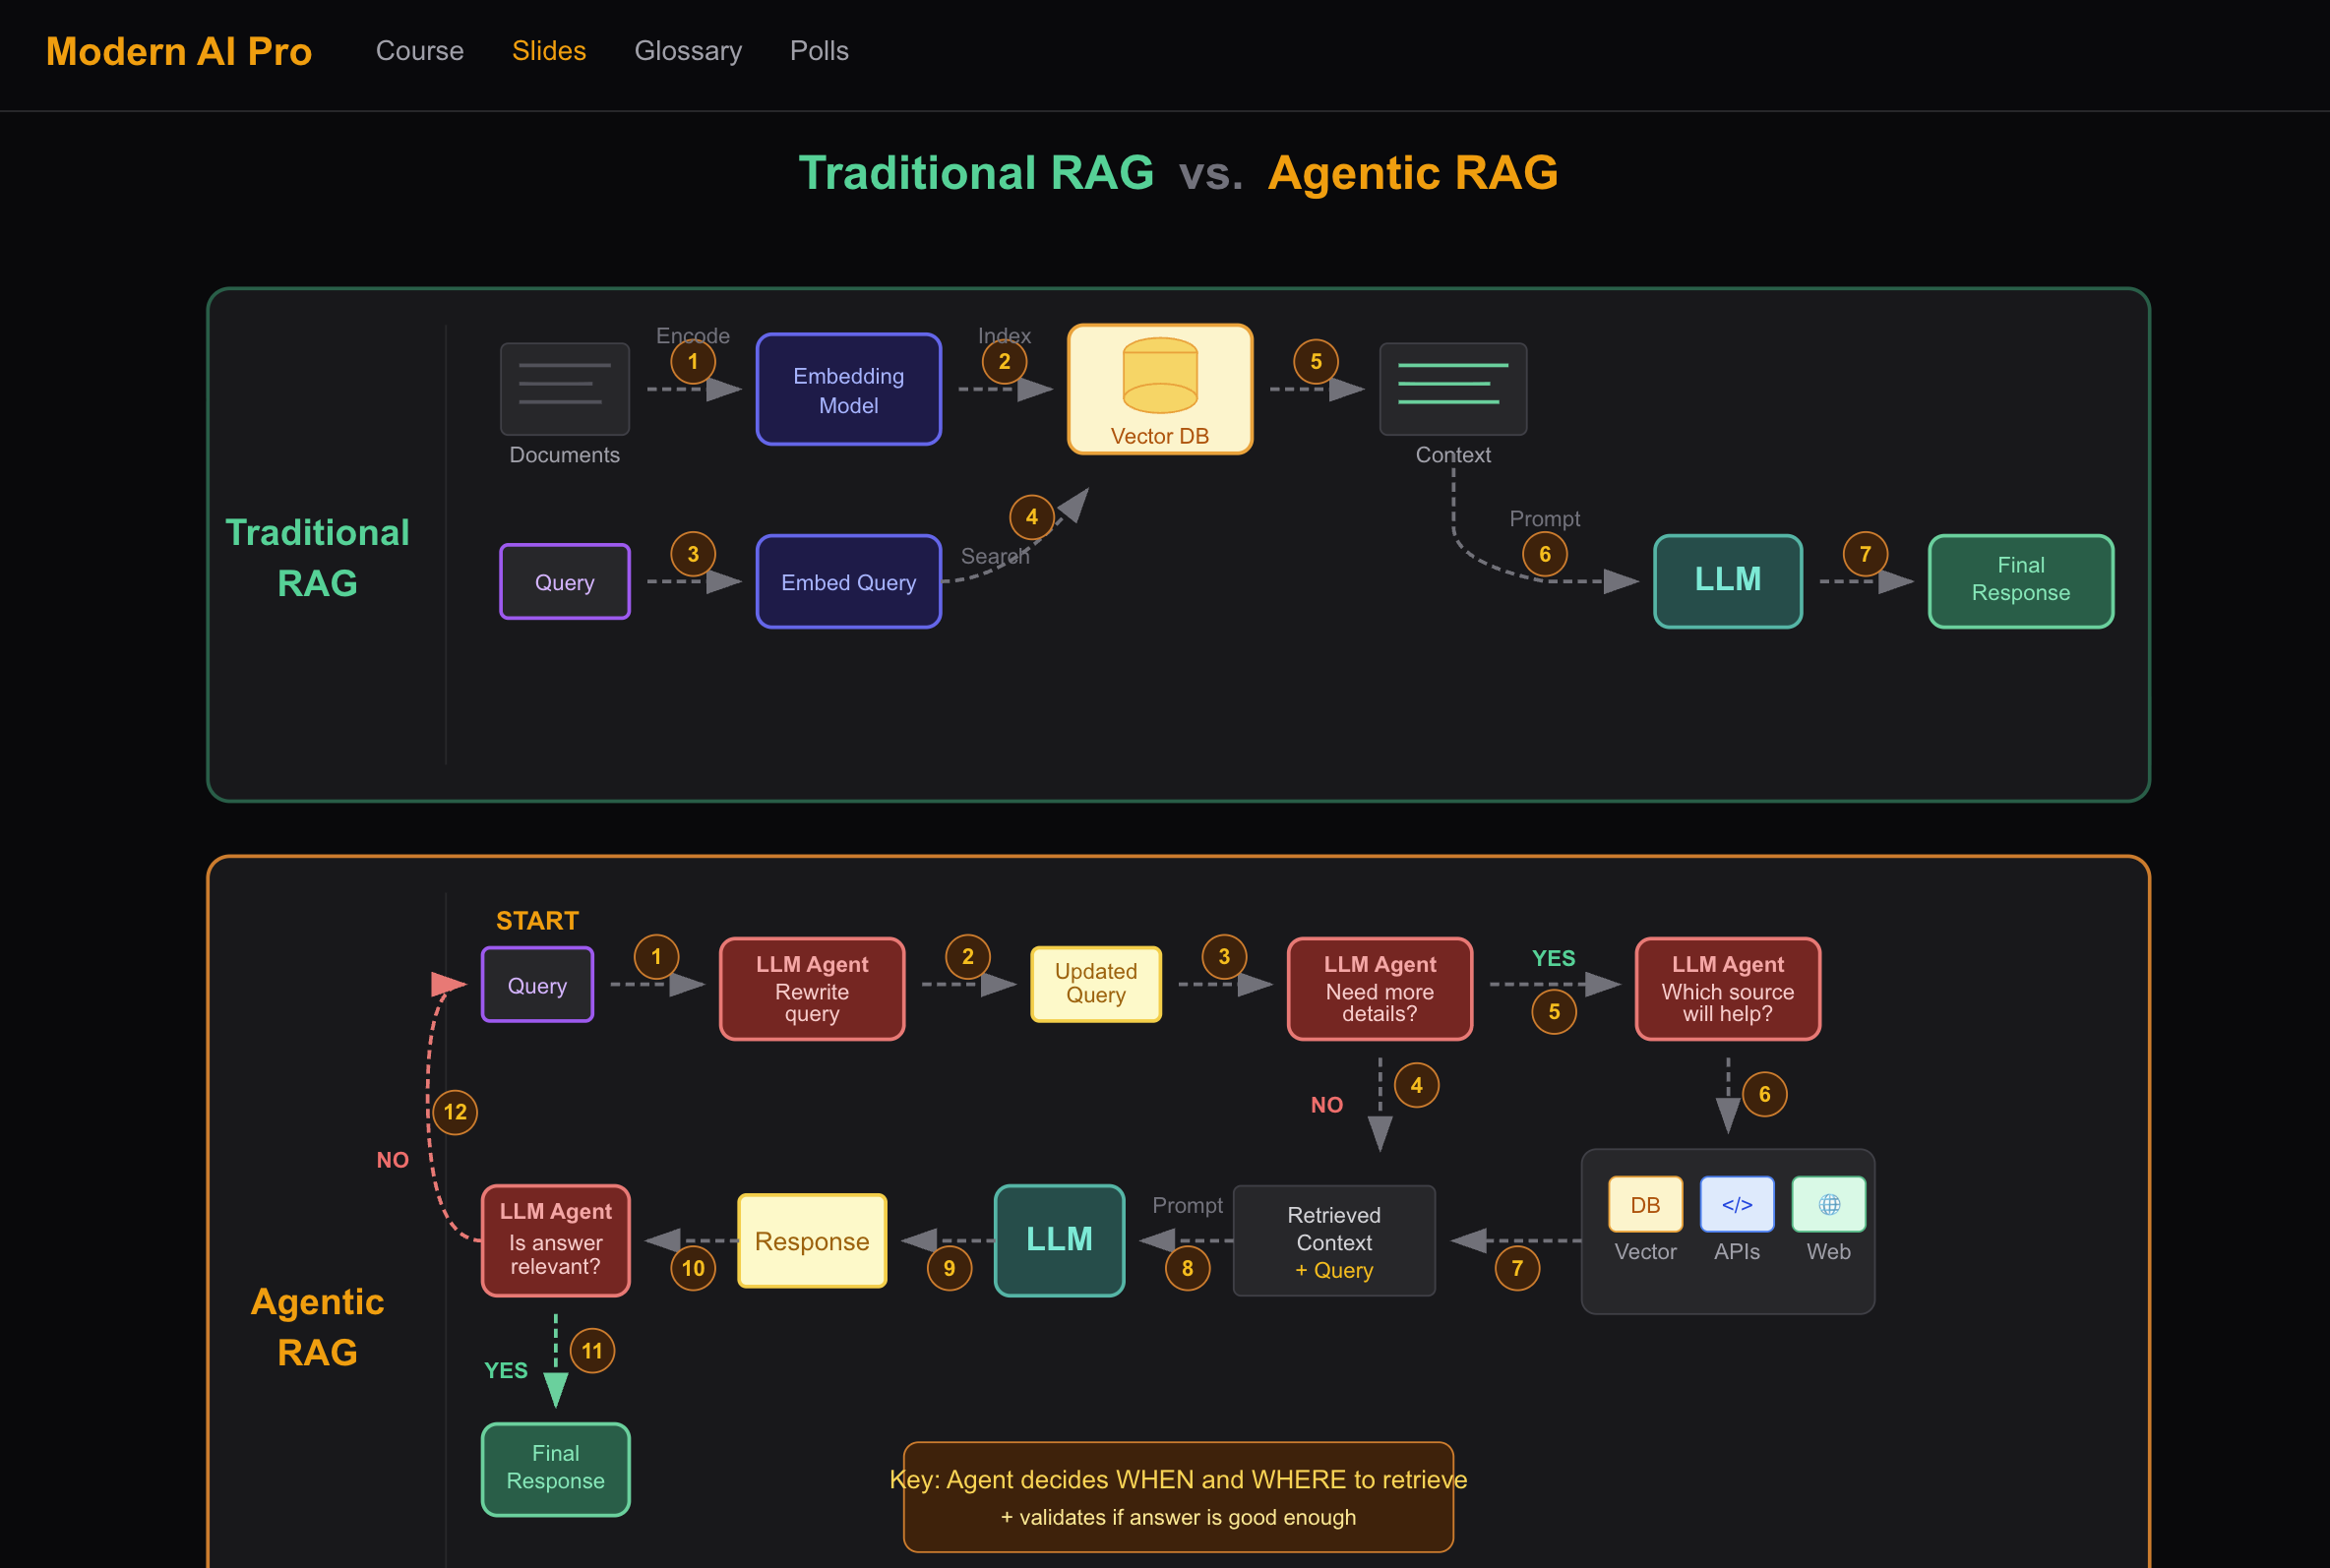

  ---
  Key Differentiator

  | Feature                                   | ChatGPT | Our System |
  |-------------------------------------------|---------|-------------|
  | Query your HR database                    | ❌       | ✅           |
  | Know your specific policies               | ❌       | ✅           |
  | Make decisions with multiple data sources | ❌       | ✅           |
  | Explain reasoning (audit trail)           | ❌       | ✅           |
  | Extensible to new domains                 | ❌       | ✅           |

###  Use Case 1: Promotion Eligibility
  "Can I get promoted?"
  Agent checks: tenure + performance reviews + goals met + manager rating + salary band
  headroom + pending actions

### Use Case 2: Sabbatical Request
  "Can I take 3-month sabbatical?"
  Agent checks: tenure + performance (not on PIP) + leave balance + team coverage + past
   decisions + policy rules

### Use Case 3: Transfer Request
  "Can I transfer to Engineering team?"
  Agent checks: skills/certifications + performance history + open positions + current
  role backfill + manager approval chain

### Use Case 4: Compensation Review
  "Am I due for a raise?"
  Agent checks: time since last raise + performance trend + market band + peer
  comparison + budget availability + promotion history


## 2. Implementation


In [ ]:
!pip install -U -q langchain langchain-community langchain-groq sentence-transformers chromadb tavily-python
# We will use a simple utility to make the text wrap properly when printing.
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:

### Step 1. Check the DB

In [ ]:
import sqlite3

try:
    # Connect to the Chinook database
    conn = sqlite3.connect("./hr_lesson.db")
    print("Opened database successfully")

    # Create a cursor object
    cursor = conn.cursor()

    # Query to list all tables in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    # Fetch all results
    tables = cursor.fetchall()

    # Check if any tables are fetched
    if tables:
        print("Tables in the database:")
        for table in tables:
            print(table[0])
    else:
        print("No tables found in the database.")

except sqlite3.Error as e:
    print(f"An error occurred: {e}")

Opened database successfully
Tables in the database:
employees
leave_balances
sqlite_sequence
benefits
compensation
performance_reviews
skills
goals


### Step 1a. Optional Explore the DB

In [ ]:
import pandas as pd
print("\n" + "=" * 70)
print("SAMPLE DATA FROM EACH TABLE")
print("=" * 70)

# 1. EMPLOYEES
print("\n📋 EMPLOYEES TABLE")
print("-" * 70)
df_employees = pd.read_sql_query("SELECT * FROM employees LIMIT 5", conn)
print(df_employees.to_string(index=False))
print(f"  Columns: {', '.join(df_employees.columns)}")

# 2. LEAVE_BALANCES
print("\n\n📋 LEAVE_BALANCES TABLE")
print("-" * 70)
df_leaves = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, l.leave_type,
           l.total_balance, l.taken_ytd, l.carryover_balance
    FROM leave_balances l
    JOIN employees e ON l.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_leaves.to_string(index=False))

# 3. BENEFITS
print("\n\n📋 BENEFITS TABLE")
print("-" * 70)
df_benefits = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, b.benefit_type,
           b.plan_name, b.status, b.premium_contribution
    FROM benefits b
    JOIN employees e ON b.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_benefits.to_string(index=False))

# 4. COMPENSATION
print("\n\n📋 COMPENSATION TABLE")
print("-" * 70)
df_comp = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, c.base_salary,
           c.bonus_eligible, c.bonus_percentage, c.promotion_eligible
    FROM compensation c
    JOIN employees e ON c.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_comp.to_string(index=False))

# 5. PERFORMANCE_REVIEWS
print("\n\n📋 PERFORMANCE_REVIEWS TABLE")
print("-" * 70)
df_reviews = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, pr.review_date,
           pr.rating, pr.comments
    FROM performance_reviews pr
    JOIN employees e ON pr.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_reviews.to_string(index=False))

# 6. SKILLS
print("\n\n📋 SKILLS TABLE")
print("-" * 70)
df_skills = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, s.skill_name,
           s.proficiency_level, s.certified
    FROM skills s
    JOIN employees e ON s.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_skills.to_string(index=False))

# 7. GOALS
print("\n\n📋 GOALS TABLE")
print("-" * 70)
df_goals = pd.read_sql_query("""
    SELECT e.first_name, e.last_name, g.goal_title,
           g.status, g.progress_percentage
    FROM goals g
    JOIN employees e ON g.employee_id = e.employee_id
    LIMIT 5
""", conn)
print(df_goals.to_string(index=False))

# ============== KEY STATISTICS ==============

print("\n\n" + "=" * 70)
print("KEY STATISTICS")
print("=" * 70)

# Departments
cursor.execute("SELECT department, COUNT(*) as count FROM employees WHERE status='Active' GROUP BY department")
print("\n📊 Active Employees by Department:")
for dept, count in cursor.fetchall():
    print(f"  {dept:.<30} {count:>3}")

# Salary ranges
cursor.execute("""
    SELECT MIN(base_salary), MAX(base_salary), AVG(base_salary)
    FROM compensation
""")
min_sal, max_sal, avg_sal = cursor.fetchone()
print(f"\n💰 Salary Range: ${min_sal:,.0f} - ${max_sal:,.0f} (Avg: ${avg_sal:,.0f})")

# Performance stats
cursor.execute("SELECT AVG(rating), MIN(rating), MAX(rating) FROM performance_reviews")
avg_rating, min_rating, max_rating = cursor.fetchone()
print(f"⭐ Performance Ratings: {min_rating:.1f} - {max_rating:.1f} (Avg: {avg_rating:.2f}/5.0)")

# Tenure stats
cursor.execute("""
    SELECT
        MIN((datetime('now') - datetime(hire_date)) / 365) as min_years,
        MAX((datetime('now') - datetime(hire_date)) / 365) as max_years,
        AVG((datetime('now') - datetime(hire_date)) / 365) as avg_years
    FROM employees
    WHERE status = 'Active'
""")
min_tenure, max_tenure, avg_tenure = cursor.fetchone()
print(f"📅 Tenure: {min_tenure:.1f} - {max_tenure:.1f} years (Avg: {avg_tenure:.1f})")

# ============== QUERY EXAMPLES (WHAT AGENTS WILL DO) ==============

print("\n\n" + "=" * 70)
print("EXAMPLES: What Agents Will Query")
print("=" * 70)

# Example 1: Check promotion eligibility
print("\n🎯 Example 1: Who is eligible for promotion?")
print("-" * 70)
df_promo = pd.read_sql_query("""
    SELECT
        e.employee_id, e.first_name, e.last_name,
        ROUND((datetime('now') - datetime(e.hire_date)) / 365, 1) as years_tenure,
        c.promotion_eligible,
        ROUND(AVG(pr.rating), 2) as avg_rating
    FROM employees e
    JOIN compensation c ON e.employee_id = c.employee_id
    LEFT JOIN performance_reviews pr ON e.employee_id = pr.employee_id
    WHERE e.status = 'Active'
    GROUP BY e.employee_id
    HAVING years_tenure >= 1 AND avg_rating >= 3.5
    LIMIT 5
""", conn)
print(df_promo.to_string(index=False))

# Example 2: Check PTO availability
print("\n\n🏖️  Example 2: Who has low PTO balance?")
print("-" * 70)
df_pto = pd.read_sql_query("""
    SELECT
        e.first_name, e.last_name,
        l.total_balance,
        l.taken_ytd,
        (l.total_balance - l.taken_ytd) as available,
        l.carryover_balance
    FROM leave_balances l
    JOIN employees e ON l.employee_id = e.employee_id
    WHERE l.leave_type = 'PTO'
    ORDER BY available
    LIMIT 5
""", conn)
print(df_pto.to_string(index=False))

# Example 3: Check skills match
print("\n\n🛠️  Example 3: Who has Python skills?")
print("-" * 70)
df_python = pd.read_sql_query("""
    SELECT
        e.first_name, e.last_name, e.department, e.role,
        s.proficiency_level, s.years_of_experience
    FROM skills s
    JOIN employees e ON s.employee_id = e.employee_id
    WHERE s.skill_name = 'Python'
    ORDER BY s.proficiency_level DESC, s.years_of_experience DESC
    LIMIT 5
""", conn)
print(df_python.to_string(index=False))

# ============== SUMMARY ==============

print("\n\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print("""
This database has:
✓ 120 employees with realistic roles and departments
✓ 480 leave balance records (tracking PTO, sick, etc.)
✓ 376 benefit records (health, dental, 401k)
✓ 120 compensation records (salary, bonuses, promotions)
✓ 301 performance reviews (2-3 per employee)
✓ 483 skill records (technical and soft skills)
✓ 181 goals (career development tracking)

Total: 2,000+ structured records
""")

print("=" * 70)



SAMPLE DATA FROM EACH TABLE

📋 EMPLOYEES TABLE
----------------------------------------------------------------------
employee_id first_name last_name                   email  department            role  hire_date   status manager_id      location salary_band          created_at
   emp_0001     Joseph   Ramirez   toddmeyer@example.org       Sales        VP Sales 2017-08-17   Remote   emp_0119 San Francisco       Entry 2025-12-07 17:45:24
   emp_0002      Barry    Mclean ashleycross@example.com       Sales       Sales Rep 2023-12-12   Active   emp_0024        Austin         Mid 2025-12-07 17:45:24
   emp_0003       Lisa   Acevedo    jrussell@example.org      Design        Designer 2019-05-20   Active   emp_0086        Denver        Lead 2025-12-07 17:45:24
   emp_0004      Tanya   Edwards   jocelyn52@example.org Engineering Junior Engineer 2025-05-28   Active   emp_0049        Denver         Mid 2025-12-07 17:45:24
   emp_0005      Amber     Scott   dorothy47@example.net      Design  D

### Step 2: Vectorize the DB

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

/tmp/ipython-input-2687525261.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from langchain_core.documents import Document
doc = []
cur = conn.cursor()
cur.execute("SELECT *  FROM skills")

rows = cur.fetchall()


for row in rows:
    combined_content = ". ".join([str(element) for element in row])
    page = Document(page_content=combined_content, metadata={"source":'Skills table'})
    doc.append(page)

print(doc)

[Document(metadata={'source': 'Skills table'}, page_content='1. emp_0001. Project Management. Beginner. 6.5. 1'), Document(metadata={'source': 'Skills table'}, page_content='2. emp_0001. Kubernetes. Beginner. 9.3. 0'), Document(metadata={'source': 'Skills table'}, page_content='3. emp_0001. SQL. Advanced. 8.4. 0'), Document(metadata={'source': 'Skills table'}, page_content='4. emp_0002. SQL. Intermediate. 11.8. 0'), Document(metadata={'source': 'Skills table'}, page_content='5. emp_0002. Problem Solving. Expert. 9.5. 0'), Document(metadata={'source': 'Skills table'}, page_content='6. emp_0002. Kubernetes. Expert. 4.9. 1'), Document(metadata={'source': 'Skills table'}, page_content='7. emp_0003. Project Management. Intermediate. 1.8. 0'), Document(metadata={'source': 'Skills table'}, page_content='8. emp_0003. SQL. Beginner. 12.7. 0'), Document(metadata={'source': 'Skills table'}, page_content='9. emp_0003. AWS. Intermediate. 9.3. 0'), Document(metadata={'source': 'Skills table'}, page_

In [ ]:
from langchain_community.vectorstores import Chroma
persist_directory = "./hr_db"
vector_db_embeddings = Chroma.from_documents(doc, embeddings, persist_directory=persist_directory)

In [ ]:
query = "databases advanced learning"
docs = vector_db_embeddings.similarity_search(query, k=5)
print(docs)

[Document(metadata={'source': 'Skills table'}, page_content='116. emp_0031. SQL. Advanced. 1.4. 1'), Document(metadata={'source': 'Skills table'}, page_content='232. emp_0058. Data Analysis. Advanced. 2.2. 1'), Document(metadata={'source': 'Skills table'}, page_content='126. emp_0033. Data Analysis. Intermediate. 2.4. 0'), Document(metadata={'source': 'Skills table'}, page_content='336. emp_0082. Data Analysis. Advanced. 4.1. 1'), Document(metadata={'source': 'Skills table'}, page_content='207. emp_0052. Data Analysis. Advanced. 9.2. 1')]


In [ ]:
from pathlib import Path
docs = [Document(page_content=f.read_text(), metadata={"title":
  f.stem.replace("_", " ")}) for f in Path(".").glob("*.md")]
docs

[Document(metadata={'title': 'Promotion Policy'}, page_content='# Promotion Policy\n**Version:** 1.5\n**Effective Date:** January 1, 2024\n**Last Updated:** January 1, 2024\n\n## Overview\nThis policy outlines the company\'s approach to career progression and promotion within the organization. Promotions recognize demonstrated performance, expanded responsibilities, and contribution to company goals.\n\n## Eligibility Criteria\n\n### Minimum Requirements\n1. **Time in current role:** Minimum 1 year of tenure in current position\n2. **Performance rating:** Most recent review rating of "Meets Expectations" or higher\n3. **Leadership rating:** If promoting to management, "Exceeds Expectations" minimum\n4. **Attendance:** No active disciplinary actions or warnings in past 12 months\n5. **Skills alignment:** Demonstrates proficiency in skills required for new role\n\n### Career Level Progression\n```\nEntry (0-2 years)    → Mid-level (2-5 years)\nMid-level (2-5 yrs)  → Senior (5-8 years)\nS

In [ ]:
persist_directory = "./policy_vectors"
vector_policy_docs = Chroma.from_documents(docs, embeddings)


In [ ]:
query = "promotion policy"
results = vector_policy_docs.similarity_search(query, k=5)
print(results)

[Document(metadata={'title': 'Promotion Policy'}, page_content='# Promotion Policy\n**Version:** 1.5\n**Effective Date:** January 1, 2024\n**Last Updated:** January 1, 2024\n\n## Overview\nThis policy outlines the company\'s approach to career progression and promotion within the organization. Promotions recognize demonstrated performance, expanded responsibilities, and contribution to company goals.\n\n## Eligibility Criteria\n\n### Minimum Requirements\n1. **Time in current role:** Minimum 1 year of tenure in current position\n2. **Performance rating:** Most recent review rating of "Meets Expectations" or higher\n3. **Leadership rating:** If promoting to management, "Exceeds Expectations" minimum\n4. **Attendance:** No active disciplinary actions or warnings in past 12 months\n5. **Skills alignment:** Demonstrates proficiency in skills required for new role\n\n### Career Level Progression\n```\nEntry (0-2 years)    → Mid-level (2-5 years)\nMid-level (2-5 yrs)  → Senior (5-8 years)\nS

### Step 3. Bring in the generator

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata
llm_groq = ChatGroq(model_name="openai/gpt-oss-20b", api_key=userdata.get("GROQ_API_KEY"))

from tavily import TavilyClient
tavily = TavilyClient(api_key=userdata.get("TAVILY_API_SEARCH"))

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("Answer this question in detail: {question} from these documents {context} pulled from our database. \
Correct the names if needed. Clean the final output for the end user, keeping only the relevant information.")
chain = (
    {"context": vector_policy_docs.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | llm_groq
    | StrOutputParser()
)

In [ ]:
print(chain.invoke("Tell me about the PTO policy"))

**Paid Time Off (PTO) Policy – Version 2.0**  
*Effective January 1, 2024 – Last Updated January 1, 2024*

---

### 1. Overview  
- PTO combines vacation, sick leave, and personal days into one flexible allowance.  

### 2. Eligibility  
- Full‑time employees earn PTO after completing a 30‑day probationary period.  

### 3. Annual PTO Allocation  

| Tenure | PTO Days / Fiscal Year |
|--------|------------------------|
| Entry Level (0–2 yrs) | 15 |
| Mid Level (2–5 yrs)   | 20 |
| Senior Level (5+ yrs) | 25 |
| Lead/Manager          | 25 |

- **Accrual**: PTO accrues monthly (1/12 of the annual allocation).  
- Part‑time employees receive a pro‑rated amount based on hours worked.  

### 4. Usage Guidelines  

| Item | Detail |
|------|--------|
| **Request & Approval** | Submit at least 2 weeks in advance for planned time. Managers must respond within 3 business days. First‑come, first‑served. |
| **Blackout Dates** | No more than 2 consecutive weeks may be approved during Q4 (Oct–Dec

In [ ]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///hr_lesson.db")

def get_schema(_):
    # fetch business documents needed for context
    return db.get_table_info()

def run_query(query):
    # Validations and protections
    # In production, really check the query coming.
    return db.run(query)

def search_web(query):
    result = tavily.search(query, max_results=3)
    return [r["content"] for r in result["results"]]

In [ ]:
get_schema(_)

"\nCREATE TABLE benefits (\n\tbenefit_id INTEGER, \n\temployee_id TEXT NOT NULL, \n\tbenefit_type TEXT NOT NULL, \n\tplan_name TEXT NOT NULL, \n\tenrollment_date DATE NOT NULL, \n\tstatus TEXT DEFAULT 'Active', \n\tpremium_contribution REAL DEFAULT 0, \n\tPRIMARY KEY (benefit_id), \n\tFOREIGN KEY(employee_id) REFERENCES employees (employee_id)\n)\n\n/*\n3 rows from benefits table:\nbenefit_id\temployee_id\tbenefit_type\tplan_name\tenrollment_date\tstatus\tpremium_contribution\n1\temp_0001\tHealth Insurance\tSilver Plan\t2025-06-22\tActive\t500.0\n2\temp_0001\tVision\tStandard Plan\t2025-09-15\tActive\t0.0\n3\temp_0002\tDental\tStandard Plan\t2025-09-15\tActive\t50.0\n*/\n\n\nCREATE TABLE compensation (\n\tcomp_id INTEGER, \n\temployee_id TEXT NOT NULL, \n\tbase_salary REAL NOT NULL, \n\tbonus_eligible INTEGER DEFAULT 1, \n\tbonus_percentage REAL DEFAULT (0.15), \n\tstock_grant_value REAL DEFAULT 0, \n\tpromotion_eligible INTEGER DEFAULT 0, \n\tyears_since_promotion REAL DEFAULT 0, \n\t

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
template = """Based on the table schema below, write a SQL query that would answer the user's question and use variations of the question and like option to search within:
{schema}

Question: {question}
Give ONLY the query without the prepending ```sql and no explanation around the code. This has to be passed to a code interpreter.
"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
query = "Which employees would be good in SQL based on their skills and goals"
sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
        | llm_groq.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)
print(sql_response.invoke({"question": query}))

SELECT e.employee_id, e.first_name, e.last_name
FROM employees e
JOIN skills s ON e.employee_id = s.employee_id
WHERE s.skill_name LIKE '%SQL%'
  AND EXISTS (
    SELECT 1
    FROM goals g
    WHERE g.employee_id = e.employee_id
      AND (g.goal_title LIKE '%SQL%' OR g.goal_description LIKE '%SQL%')
  );


In [ ]:
sql_chain = (
    RunnablePassthrough.assign(query=sql_response).assign(
        schema=get_schema,
        response=lambda x: run_query(x["query"]),
    )
)
response = sql_chain.invoke({
    "question": (
       query
    )
})

response

{'question': 'Which employees would be good in SQL based on their skills and goals',
 'query': "SELECT DISTINCT e.employee_id, e.first_name, e.last_name\nFROM employees e\nJOIN skills s ON e.employee_id = s.employee_id\nJOIN goals g ON e.employee_id = g.employee_id\nWHERE s.skill_name LIKE '%SQL%'\n  AND (g.goal_title LIKE '%SQL%' OR g.goal_description LIKE '%SQL%');",
 'schema': "\nCREATE TABLE benefits (\n\tbenefit_id INTEGER, \n\temployee_id TEXT NOT NULL, \n\tbenefit_type TEXT NOT NULL, \n\tplan_name TEXT NOT NULL, \n\tenrollment_date DATE NOT NULL, \n\tstatus TEXT DEFAULT 'Active', \n\tpremium_contribution REAL DEFAULT 0, \n\tPRIMARY KEY (benefit_id), \n\tFOREIGN KEY(employee_id) REFERENCES employees (employee_id)\n)\n\n/*\n3 rows from benefits table:\nbenefit_id\temployee_id\tbenefit_type\tplan_name\tenrollment_date\tstatus\tpremium_contribution\n1\temp_0001\tHealth Insurance\tSilver Plan\t2025-06-22\tActive\t500.0\n2\temp_0001\tVision\tStandard Plan\t2025-09-15\tActive\t0.0\n3\t

In [ ]:
print(response['response'])

### Step 4. Routing


In [ ]:
SOURCE_CONTEXT = """
  You are an HR assistant. You have access to 2 data sources:

  SQL Database - Use for EMPLOYEE-SPECIFIC data:
  - Employee details (name, department, hire_date, salary)
  - Leave balances (PTO taken, remaining days)
  - Performance reviews (ratings, review dates)
  - Compensation history

  Vector Database - Use for POLICY/RULES questions:
  - PTO Policy (how much leave, carryover rules)
  - Promotion Policy (eligibility criteria, process)
  - Sabbatical Policy (who qualifies, duration)
  - Compensation Policy (salary bands, bonus structure)
  """

In [ ]:
def write_sql_query(question):
      schema = get_schema(_)
      prompt = f"""You are a SQL expert. Write a SQLite query to answer this question.

  Schema:
  {schema}

  Question: {question}

  Return ONLY the SQL query, nothing else.
  """
      return llm_groq.invoke(prompt).content.strip()

print(write_sql_query("Find employees who are good in Python"))

SELECT e.employee_id, e.first_name, e.last_name
FROM employees e
JOIN skills s ON e.employee_id = s.employee_id
WHERE s.skill_name = 'Python'
  AND s.proficiency_level IN ('Advanced', 'Expert');


In [ ]:
def analyze_query(question):
      prompt = f"""{SOURCE_CONTEXT}

  User Question: {question}

  Respond in this exact format:
  SOURCE: [SQL or VECTOR or BOTH]
  REWRITTEN: [optimized search query]
  REASON: [one line why]
  """
      return llm_groq.invoke(prompt).content

test_questions = [
      "How much PTO does John Smith have left?",
      "What are the requirements for promotion?",
      "Is Sarah eligible for sabbatical based on her tenure?"
  ]

for q in test_questions:
      print(f"Q: {q}")
      print(analyze_query(q))
      print("-" * 50)

Q: How much PTO does John Smith have left?
SOURCE: SQL  
REWRITTEN: `SELECT e.name, lb.pto_remaining FROM employees e JOIN leave_balances lb ON e.id = lb.employee_id WHERE e.name = 'John Smith';`  
REASON: Retrieve John Smith’s current PTO balance from employee‑specific tables.
--------------------------------------------------
Q: What are the requirements for promotion?
SOURCE: VECTOR  
REWRITTEN: "promotion policy eligibility criteria"  
REASON: The question concerns company promotion rules, which are stored in the policy vector database.
--------------------------------------------------
Q: Is Sarah eligible for sabbatical based on her tenure?
SOURCE: BOTH  
REWRITTEN: SELECT hire_date FROM employees WHERE name='Sarah'; SEARCH sabbatical policy for tenure eligibility  
REASON: Need Sarah's hire date from SQL and the sabbatical eligibility rules from the vector policy database.
--------------------------------------------------


In [ ]:
def route_query(question):
      analysis = analyze_query(question)
      print(f"Analysis:\n{analysis}\n")
      results = {}

      if "SQL" in analysis:
          try:
              sql = write_sql_query(question)
              print(f"Generated SQL: {sql}")
              results["sql"] = db.run(sql)
          except Exception as e:
              results["sql_error"] = str(e)
              print(f"⚠️ SQL Error: {e}")

      if "VECTOR" in analysis:
          results["vector"] = vector_policy_docs.similarity_search(question, k=2)

      if "WEB" in analysis:
          try:
              results["web"] = search_web(question)
          except Exception as e:
              results["web_error"] = str(e)
              print(f"⚠️ Web Error: {e}")

      return analysis, results

In [ ]:
def get_confidence(question, answer, results):
      sources_used = len([k for k in results.keys() if not k.endswith("_error")])
      prompt = f"""Rate confidence (LOW/MEDIUM/HIGH) for this answer.

      Question: {question}
      Answer: {answer}
      Sources used: {sources_used}

      Return only: LOW, MEDIUM, or HIGH"""
      return llm_groq.invoke(prompt).content.strip()


In [ ]:
source, results = route_query("How much PTO does emp_0001 have?")
print(f"\nSource: {source}")
print(f"Results: {results}")

source, results = route_query("Is emp_0001 eligible for promotion based on policy?")
print(f"\nSource: {source}")
print(f"Results: {results}")

Analysis:
SOURCE: SQL  
REWRITTEN: SELECT pto_remaining FROM leave_balances WHERE employee_id = 'emp_0001';  
REASON: PTO balance is employee‑specific data stored in the SQL database.

Generated SQL: SELECT total_balance
FROM leave_balances
WHERE employee_id = 'emp_0001'
  AND leave_type = 'PTO';

Source: SOURCE: SQL  
REWRITTEN: SELECT pto_remaining FROM leave_balances WHERE employee_id = 'emp_0001';  
REASON: PTO balance is employee‑specific data stored in the SQL database.
Results: {'sql': '[(25.0,)]'}
Analysis:
SOURCE: BOTH  
REWRITTEN: SELECT e.name, e.department, e.hire_date, e.salary, pr.rating, pr.review_date FROM employees e JOIN performance_reviews pr ON e.id = pr.employee_id WHERE e.id = 'emp_0001'; -- vector_search('Promotion Policy')  
REASON: Requires both employee performance data and the promotion policy to assess eligibility.


Source: SOURCE: BOTH  
REWRITTEN: SELECT e.name, e.department, e.hire_date, e.salary, pr.rating, pr.review_date FROM employees e JOIN performan

### Step 5. Synthesis

In [ ]:
def synthesize_answer(question, source, results):
      context = ""

      if "sql" in results:
          context += f"Employee Data:\n{results['sql']}\n\n"

      if "vector" in results:
          policies = "\n".join([r.page_content[:500] for r in results["vector"]])
          context += f"Policy Information:\n{policies}\n"

      prompt = f"""Based on the following information, answer the user's question.

  {context}

  Question: {question}

  Provide a clear, helpful answer:"""

      return llm_groq.invoke(prompt).content

In [ ]:
def ask_hr(question):
      print(f"❓ Question: {question}\n")

      # Route & retrieve
      source, results = route_query(question)
      print(f"📍 Source used: {source}\n")

      # Synthesize
      answer = synthesize_answer(question, source, results)
      print(f"💬 Answer:\n{answer}")

      confidence = get_confidence(question, answer, results)
      print(f"🎯 Confidence: {confidence}")

      return answer

In [ ]:
ask_hr("How much PTO does emp_0001 have left?")

❓ Question: How much PTO does emp_0001 have left?

Analysis:
SOURCE: SQL  
REWRITTEN: SELECT remaining_days FROM leave_balances WHERE employee_id = 'emp_0001';  
REASON: Directly fetches PTO remaining days for the specified employee.

Generated SQL: SELECT total_balance - taken_ytd AS pto_left
FROM leave_balances
WHERE employee_id = 'emp_0001'
  AND leave_type = 'PTO';
📍 Source used: SOURCE: SQL  
REWRITTEN: SELECT remaining_days FROM leave_balances WHERE employee_id = 'emp_0001';  
REASON: Directly fetches PTO remaining days for the specified employee.

💬 Answer:
emp_0001 has **approximately 14.06 hours of PTO remaining**.
🎯 Confidence: HIGH


'emp_0001 has **approximately 14.06 hours of PTO remaining**.'

In [ ]:
!pip install gradio
import gradio as gr

def chat(message, history):
    return ask_hr(message)

demo = gr.ChatInterface(
    fn=chat,
    title="Agentic RAG chatbot",
    description="This is a chatbot built as part of Modern AI Pro Essentials program",
)
demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7287fa80cbf78bc2e9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


❓ Question: does emp 011 have PTO left?

Analysis:
SOURCE: SQL  
REWRITTEN: SELECT remaining_days FROM leave_balances WHERE employee_id = '011';  
REASON: Employee-specific PTO balance requires SQL lookup.

Generated SQL: SELECT 
    CASE 
        WHEN SUM(total_balance - taken_ytd) > 0 THEN 'Yes' 
        ELSE 'No' 
    END AS has_pto_left
FROM leave_balances
WHERE employee_id = 'emp_0119' 
  AND leave_type = 'PTO';
📍 Source used: SQL

💬 Answer:
**Answer:** Yes, employee 011 has PTO left.  
The provided data shows a single entry of `('Yes',)`, which indicates that the employee has remaining paid time off.
❓ Question: tell me about the PTO policies

Analysis:
SOURCE: VECTOR  
REWRITTEN: `SELECT * FROM policies WHERE category='PTO'`  
REASON: Efficiently retrieves the PTO policy details from the policy vector database.

📍 Source used: VECTOR

💬 Answer:
**Paid Time Off (PTO) – Company Policy (Version 2.0, Effective Jan 1 2024)**  

| Section | Key Points |
|---------|------------|
| **Pu